# Multi Layer Perceptron

Most probably, MLP is the first step in the deep learning.The name __Deep Learning__ comes from the concept that computer scientists hope to mimic the brain structure with the same functionality of the neurons. That is why the MLPs are also called __Neural Networks__. The key feature of this model is that it can discremenate data which is __NOT__ linearly separable.
We assume that you have the basic knowledge over the concept and you are just interested in the __Tensorflow__ implementation of the MLPs. If you want to know more about the MLPs and Neural Nets we suggest you to take [this](https://www.coursera.org/learn/machine-learning) amazing course on machine learning.
To build any classifier, your code needs specific parts:
1. Prepare the needed libraries, input data and hyper-parameters for the network
2. Build the graph of the network
3. Train the network
4. Test the network


## 1. Prepration:
### 1.1 Imports:
We will start with importing the needed libraries for our code.

In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 1.2 Input data:
For this tutorial we use the MNIST dataset. MNIST is a dataset of handwritten digits. If you are into machine learning, you might have heard of this dataset by now. MNIST is kind of benchmark of datasets for deep learning. One other reason that we use the MNIST is that it is easily accesible through Tensorflow.
If you want to know more about the MNIST dataset you can check __Yann Lecun__'s [website](http://yann.lecun.com/exdb/mnist/).

We can easily import the dataset and see the size of training, test and validation set:

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### 1.3 Hyper-parameters:
Hyper-parameters are important parameters which are not learned by the network. So, we have to specify them externally. These parameters are constant and they are not learnable.

In [3]:
# hyper-parameters
learning_rate = 0.001  # The optimization learning rate
epochs = 10  # Total number of training epochs
batch_size = 100  # Training batch size
display_freq = 100  # Frequency of displaying the training results

# Network Parameters
# We know that MNIST images are 28 pixels in each dimension.
img_h = img_w = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_h * img_w

# Number of classes, one class for each of 10 digits.
n_classes = 10

# number of units in the first hidden layer
h1 = 200

## 2. Graph:
Before we start constructing the graph, there are some functions that we need rapidly. So, instead of calling them for several times, we will define some useful functions and we will call them inside our graph. The most important ones are for creating wieght and bias variables. Since we are creating a MLP, we need a fully connected layer to connect all the nodes from the previous layer to our layer.

In [4]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    name: weight name
    shape: weight shape
    
    return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    name: bias variable name
    shape: bias variable shape
    
    return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)


def fc_layer(x, num_nodes, name, use_relu=True):
    """
    Creates a fully-connected layer
    :param x: input from previous layer
    :param num_nodes: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim, num_nodes])
    b = bias_variable(name, [num_nodes])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

Now that we have our helper functions we can create our graph:

In [5]:
# Create graph
# Placeholders for inputs (x), outputs(y)
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
fc1 = fc_layer(x, h1, 'FC1', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Network predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

# Initializing the variables
init = tf.global_variables_initializer()

## 3. Train:
As soon as the graph is created, we can run it on a session. A ```tf.Session()``` is as good as it's runtime. As soon as the cell is run, the session will be ended and we will loose all the information. So. we will define an __InteractiveSession__ to keep the parameters for testing.

In [6]:
# Launch the graph (session)
sess = tf.InteractiveSession() # using InteractiveSession instead of Session to test network in separate cell
sess.run(init)
# Number of training iterations in each epoch
num_tr_iter = int(mnist.train.num_examples / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch+1))
    for iteration in range(num_tr_iter):
        batch_x, batch_y = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop)
        feed_dict_batch = {x: batch_x, y: batch_y}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)
            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: mnist.validation.images, y: mnist.validation.labels}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.28,	Training Accuracy=56.0%
iter 100:	 Loss=0.33,	Training Accuracy=94.0%
iter 200:	 Loss=0.24,	Training Accuracy=94.0%
iter 300:	 Loss=0.14,	Training Accuracy=98.0%
iter 400:	 Loss=0.25,	Training Accuracy=92.0%
iter 500:	 Loss=0.27,	Training Accuracy=90.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.20, validation accuracy: 94.7%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.26,	Training Accuracy=96.0%
iter 100:	 Loss=0.22,	Training Accuracy=91.0%
iter 200:	 Loss=0.27,	Training Accuracy=94.0%
iter 300:	 Loss=0.16,	Training Accuracy=95.0%
iter 400:	 Loss=0.15,	Training Accuracy=95.0%
iter 500:	 Loss=0.14,	Training Accuracy=96.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.14, validation accuracy: 96.0%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.07,	Training Accuracy=98

## 4. Test:
Now that the model is trained. It is time to test our model. We will define some helper functions to plot some of the images and their corresponding predicted and true classes. We will also visualize some of the misclassified samples to see why the MLP failed to classify them correctly.

In [7]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    img_h = img_w = np.sqrt(images.shape[-1]).astype(int)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((img_h, img_w)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    if title:
        plt.suptitle(title, size=20)
    plt.show()
    
    
def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

---------------------------------------------------------
Test loss: 0.07, test accuracy: 98.0%
---------------------------------------------------------


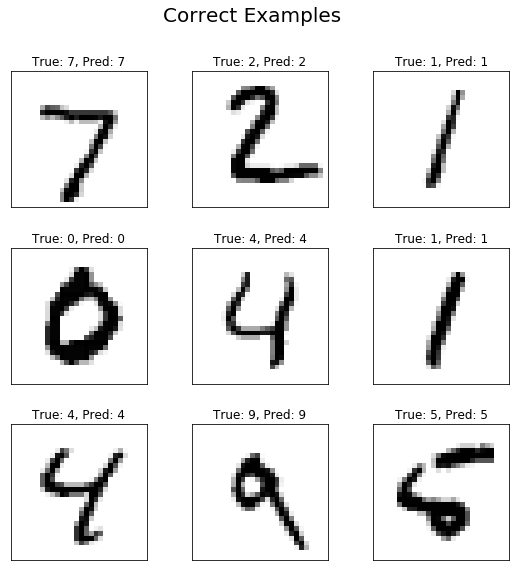

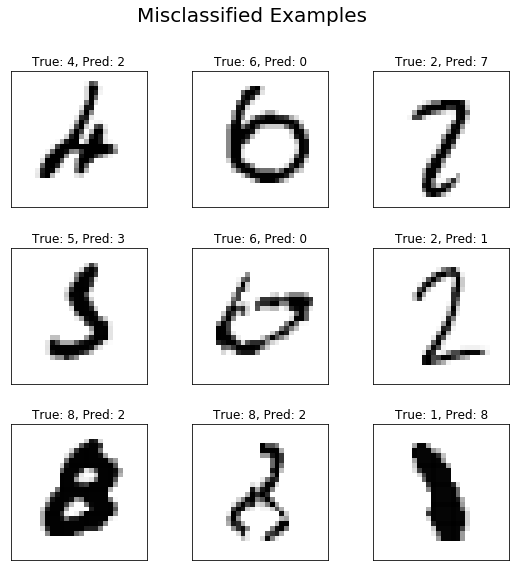

In [8]:
# Test the network after training
# Accuracy
feed_dict_test = {x: mnist.test.images, y: mnist.test.labels}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(mnist.test.labels, axis=1)
plot_images(mnist.test.images, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(mnist.test.images, cls_true, cls_pred, title='Misclassified Examples')

After we are finished the testing, we will close the session to free the memory.

In [9]:
# close the session after you are done with testing
sess.close()

As it can be seen some of the examples are even hard for human to be classified. But we will see in the future that there are better networks (like Conv)